# Step #1 Load the Data

In [34]:
import math 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

import seaborn as sns

# Load the train data
path = 'data/sentiment-analysis/'
train_base_df = pd.read_csv(path + "train.csv") 
test_base_df = pd.read_csv(path + "test.csv") 

# Print a Summary of the Train Data
# The train data comprises 27481 text phrases 
# Sentiment Classes are labeled either "neutral", "negative" or "positive"
train_base_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


# Step #2 Clean and Preprocess the Data

In [35]:
# Define Class Integer Values
cleanup_nums = {"sentiment": {"negative": 1, "neutral": 2, "positive": 3}}

# Replace the Classes with Integer Values
train_df = train_base_df.copy()
train_df.replace(cleanup_nums, inplace=True)

# Clean the Test Data
test_df = test_base_df.copy()
test_df.replace(cleanup_nums, inplace=True)

# Create a Feature based on Text Length
train_df['text_length'] = train_df['text'].str.len() # Store string length of each sample
train_df = train_df.sort_values(['text_length'], ascending=True)
train_df = train_df.dropna()
train_df 

,textID,text,selected_text,sentiment,text_length
14339,5c6abc28a1,ow,ow,2,3.0
26005,0b3fe0ca78,?,?,2,3.0
11524,4105b6a05d,aw,aw,2,3.0
641,5210cc55ae,no,no,2,3.0
25699,ee8ee67cb3,ME,ME,2,3.0
...,...,...,...,...,...
2582,72df0ca5a2,TODAy SUCKs - kisskass19: ï¿½you and katey bro...,SUCKs,1,139.0
16851,a7595518c2,"4 novos followers http://migre.me/SfN Sorry, t...","Sorry,",1,139.0
13896,3312d3de45,Feeling madly sorry for myself... - ï¿½Iï¿½M S...,madly sorry,1,140.0
27318,d370238b6b,just saw an advert for ATTICS TO EDEN on tv o...,just saw an advert for ATTICS TO EDEN on tv o...,2,141.0


# Step #3 Explore the Data

Text(0, 0.5, 'Labels')

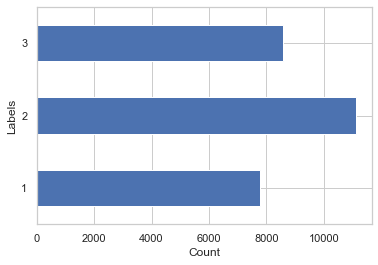

In [36]:
# Print the Distribution of Sentiment Labels
sns.set_theme(style="whitegrid")
ax = train_df['sentiment'].value_counts(sort=False).plot(kind='barh', color='b')
ax.set_xlabel('Count')
ax.set_ylabel('Labels')

Text(0.5, 1.0, 'Text Length Distribution')

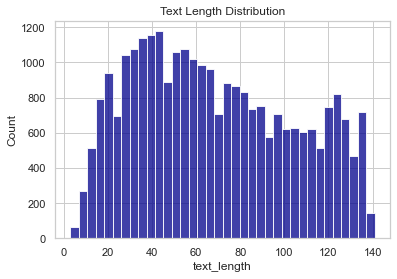

In [37]:
# Visualize a distribution of text_length
sns.histplot(data=train_df, x='text_length', bins='auto', color='darkblue');
plt.title('Text Length Distribution')

# Step #4a Train a Logistic Regression Classifier

              precision    recall  f1-score      support
negative       0.736479  0.639361  0.684492  1001.000000
neutral        0.643070  0.755944  0.694953  1430.000000
positive       0.795732  0.709882  0.750359  1103.000000
accuracy       0.708546  0.708546  0.708546     0.708546
macro avg      0.725093  0.701729  0.709935  3534.000000
weighted avg   0.717175  0.708546  0.709283  3534.000000


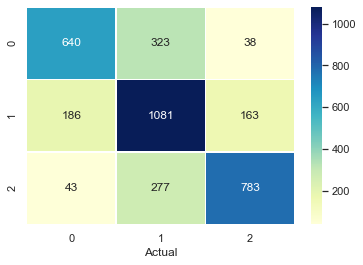

In [38]:
# Create a transformation pipeline
# The pipeline sequentially applies a list of transforms and as a final estimator logistic regression 
pipeline_log = Pipeline([
                ('count', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='liblinear', multi_class='auto')),
        ])

# Train model using the created sklearn pipeline
model_name = 'logistic regression classifier'
model_lgr = pipeline_log.fit(train_df['text'], train_df['sentiment'])

def evaluate_results(model, test_df):
    # Predict class labels using the learner function
    test_df['pred'] = model.predict(test_df['text'])
    y_true = test_df['sentiment']
    y_pred = test_df['pred']
    target_names = ['negative', 'neutral', 'positive']

    # Print the Confusion Matrix
    results_log = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    results_df_log = pd.DataFrame(results_log).transpose()
    print(results_df_log)
    matrix = confusion_matrix(y_true,  y_pred)
    sns.heatmap(pd.DataFrame(matrix), 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel('Predictions')
    plt.xlabel('Actual')
    
    model_score = score(y_pred, y_true, average='macro')
    return model_score

    
# Evaluate model performance
model_score = evaluate_results(model_lgr, test_df)
performance_df = pd.DataFrame().append({'model_name': model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

# Step #4b Train a Bayes Classifier

              precision    recall  f1-score      support
negative       0.782700  0.370629  0.503051  1001.000000
neutral        0.531678  0.868531  0.659586  1430.000000
positive       0.821823  0.539438  0.651341  1103.000000
accuracy       0.624788  0.624788  0.624788     0.624788
macro avg      0.712067  0.592866  0.604659  3534.000000
weighted avg   0.693337  0.624788  0.612674  3534.000000


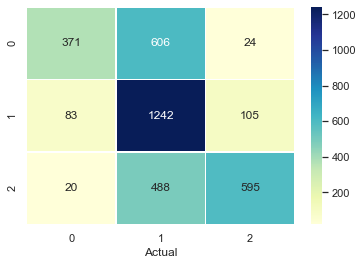

In [39]:
# Create a pipeline which transforms phrases into normalized feature vectors and uses a bayes estimator
model_name = 'bayes classifier'

pipeline_bayes = Pipeline([
                ('count', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('gnb', MultinomialNB()),
                ])

# Train model using the created sklearn pipeline
model_bayes = pipeline_bayes.fit(train_df['text'], train_df['sentiment'])

# Evaluate model performance
model_score = evaluate_results(model_bayes, test_df)
performance_df = performance_df.append({'model_name': model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

# Step #5 Compare Classifier Performance

   f1_score                      model_name  precision    recall
0  0.701729  logistic regression classifier   0.725093  0.709935
1  0.592866                bayes classifier   0.712067  0.604659


Text(0.5, 1.0, 'Model Outlier Detection Performance (Macro)')

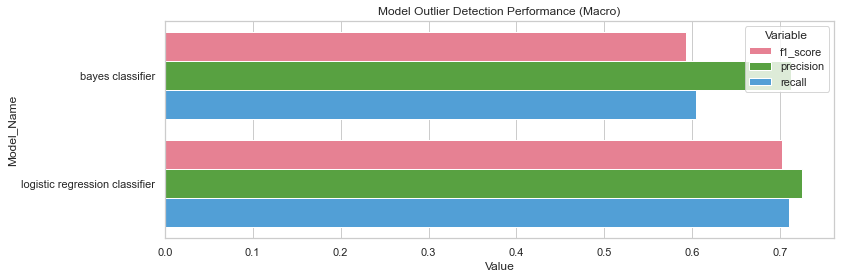

In [40]:
# Compare model performance
print(performance_df)

performance_df = performance_df.sort_values('model_name')
fig, ax = plt.subplots(figsize=(12, 4))
tidy = performance_df.melt(id_vars='model_name').rename(columns=str.title)
sns.barplot(y='Model_Name', x='Value', hue='Variable', data=tidy, ax=ax, palette='husl',  linewidth=1, edgecolor="w")
plt.title('Model Outlier Detection Performance (Macro)')

# Step #6 Make Test Predictions

In [41]:
testphrases = ['Mondays just suck!', 'I love this product', 'That is a tree', 'Terrible service']
for testphrase in testphrases:
    resultx = model_lgr.predict([testphrase]) # use model_bayes for predictions with the other model
    dict = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
    print(testphrase + '-> ' + dict[resultx[0]])

Mondays just suck!-> Negative
I love this product-> Positive
That is a tree-> Neutral
Terrible service-> Negative
